In [5]:
# %reset -f
# %reload_ext autoreload
# %autoreload 2
%matplotlib inline
# %matplotlib widget
# %matplotlib agg

import subprocess as sp
import sys,os,shutil
import numpy as np
from os.path import join

try:
    import xpdtools    
except:
    try:
        import google.colab
        print('installing conda stuff \n this may take a while...')
        sp.call('wget -c https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh',shell=True)
        sp.call('chmod +x Miniconda3-latest-Linux-x86_64.sh',shell=True)
        sp.call('bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p  /usr/local',shell=True)
        sp.call('conda install -yc conda-forge xpdtools',shell=True)
        sys.path.append('/usr/local/lib/python3.6/site-packages/')
        print('Finished...')
    except:
        print('Unable to import/install xpdtools...')     

In [6]:
from os.path import expanduser
gd_path=join(expanduser("~"),'gd')
if not os.path.isdir(gd_path):
    try:
        # load Google Drive
        from google.colab import drive,files
        drive.mount('/drive')
        sp.call('ln -s /drive/My\ Drive '+gd_path, shell=True)
    except:
        print('unable to find Google Drive Folder')
os.listdir(gd_path)

['code', '.directory', 'work', 'temp', '.insync-trash']

In [9]:
tiff_id='LaB6_SPIN_20181005-035312_dx_47.000mm_63650b_0001'
meta_id='LaB6_SPIN_63650b'

In [17]:
# generate poni file from yaml
import yaml
meta = yaml.load(open(meta_id+'.yaml', 'r') )
from pyFAI.azimuthalIntegrator import AzimuthalIntegrator
ai = AzimuthalIntegrator()
ai.setPyFAI(**meta['calibration_md'])
ai.save(meta_id+'.poni') ## NOTE: doesn't overwrite
wl=meta['bt_wavelength']

In [30]:
# mask and integrate tiff file
import tifffile

try:
    del xpdtools_processtiff
except:
    pass
from xpdtools.cli.process_tiff import main as xpdtools_processtiff

xpdtools_processtiff(image_files=tiff_id+'.tiff', poni_file=meta_id+'.poni', bg_file=None,
         mask_file=None, polarization=0.99, edge=20, lower_thresh=None,
         alpha=2.5, auto_type='median', mask_settings='auto');

{'edge': 20, 'lower_thresh': None, 'upper_thresh': None, 'alpha': 2.5, 'auto_type': 'median', 'tmsk': None}


/home/mt/software/miniconda3/lib/python3.6/site-packages/skbeam/core/accumulators/binned_statistic.py:349: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.result = self.result[core]


start auto mask
finished auto mask


/home/mt/software/miniconda3/lib/python3.6/site-packages/skbeam/core/accumulators/binned_statistic.py:349: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.result = self.result[core]
/home/mt/software/miniconda3/lib/python3.6/site-packages/rapidz/core.py:698: RuntimeWarning: invalid value encountered in true_divide
  result = self.func(*y, **self.kwargs)


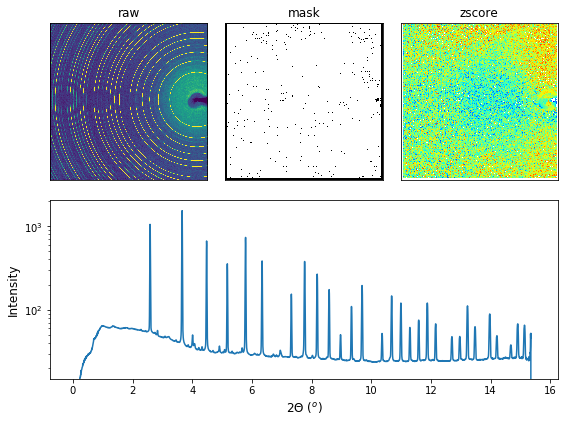

In [33]:
# plot
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot('231')
ax.imshow(tifffile.imread(tiff_id+'.tiff'),vmin=10,vmax=100,cmap='viridis')
ax.set_xticks([]);ax.set_yticks([])
ax.set_title('raw')

ax = fig.add_subplot('232')
ax.imshow(np.load(tiff_id+'_mask.npy'),cmap='gray')
ax.set_xticks([]);ax.set_yticks([])
ax.set_title('mask')

ax = fig.add_subplot('233')
ax.imshow(tifffile.imread(tiff_id+'_zscore.tif'),cmap='jet')
ax.set_xticks([]);ax.set_yticks([])
ax.set_title('zscore')

ax = fig.add_subplot('212')
chi = np.loadtxt(tiff_id+'.chi',skiprows=8,unpack=True)
# convert Q to 2Theta
pre_factor = wl / (4 * np.pi)
TTH = np.rad2deg( 2 * np.arcsin( chi[0] * pre_factor) )  
ax.plot(TTH,chi[1])
ax.set_yscale('log')
ax.set_ylim(bottom=15)
ax.set_xlabel(u'2$\Theta$ ($^o$)', fontsize=12)
ax.set_ylabel(u'Intensity', fontsize=12)
np.savetxt(tiff_id+'.xy', np.transpose((TTH,chi[1])),  
           header='2Theta    Intensity', delimiter='  ', fmt='%2.4e')


plt.tight_layout()
plt.savefig(tiff_id+'.pdf')

In [34]:
for c in ['_mask.npy','.msk','.chi','_median.chi','_std.chi','_zscore.tif']:
    try:
        os.remove(tiff_id+c)
    except:
        pass

In [23]:
# download = "pdf" #@param ["chi", "pdf", "msk"]
# files.download('img.'+download)